In [2]:
import tensorflow as tf
import keras_tuner
import numpy as np
import matplotlib.pyplot as plt

In [14]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [15]:
X_train.shape

(60000, 28, 28)

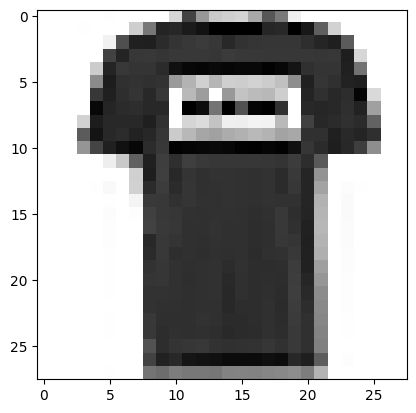

In [18]:
plt.imshow(X_train[1], cmap='binary')
plt.show()

In [39]:
def create_model(hyper_paramters = False):

    num_hidden_layer = 1
    num_units = 8
    dropout_rate = 0.1
    learning_rate_ = 0.01

    if hyper_paramters:
        num_hidden_layer = hyper_paramters.Choice('num_hidden_layers', values = [1,2,3])
        num_units = hyper_paramters.Choice('num_units', values = [8, 16, 32])
        dropout_rate = hyper_paramters.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
        learning_rate_ = hyper_paramters.Float('learinig_rate', min_value = 0.0001, max_value = 0.01)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (28,28))) #Flatten the image
    model.add(tf.keras.layers.Lambda(lambda x: x/255)) # normalize the input

    for i in range(0, num_hidden_layer):
        model.add(tf.keras.layers.Dense(num_units, activation = 'tanh'))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_), metrics=['accuracy'])

    return model



In [40]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [47]:
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
        # Call the parent class's run_trial method
        metrics = super(CustomTuner, self).run_trial(trial, *args, **kwargs)
        
        # Return the evaluation metrics
        return metrics


In [48]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name = 'fashion_mnist',
    overwrite = True
)

In [49]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learinig_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [50]:
tuner.search(
    X_train,y_train,
    validation_data = [X_test,y_test],
    epochs = 5,
    verbose = True,
)

models = tuner.get_best_models(num_models=1)

Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.7839999794960022

Best val_accuracy So Far: 0.8511000275611877
Total elapsed time: 00h 02m 58s
INFO:tensorflow:Oracle triggered exit


In [51]:
tuner.results_summary(1)

Results summary
Results in logs\fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 15 summary
Hyperparameters:
num_hidden_layers: 2
num_units: 32
dropout_rate: 0.1047779351627019
learinig_rate: 0.004646267427829259
batch_size: 128
Score: 0.8511000275611877


In [53]:
models = models[0]

In [54]:
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                3

In [55]:
models.fit(
    X_train, y_train,
    validation_data = [X_test, y_test],
    epochs = 20,
    batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=3)]
)


Epoch 1/20
469/469 [==============================] - 2s 2ms/step - loss: 0.3927 - accuracy: 0.8591 - val_loss: 0.4349 - val_accuracy: 0.8417
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3851 - accuracy: 0.8606 - val_loss: 0.3942 - val_accuracy: 0.8564
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3789 - accuracy: 0.8626 - val_loss: 0.3847 - val_accuracy: 0.8637
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3738 - accuracy: 0.8647 - val_loss: 0.4073 - val_accuracy: 0.8561
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3680 - accuracy: 0.8676 - val_loss: 0.3919 - val_accuracy: 0.8553
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3663 - accuracy: 0.8689 - val_loss: 0.3945 - val_accuracy: 0.8585
